# Overview

# Business Understanding

# Data Understanding

## Data Preparation

In [3106]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import gmean
import statistics

In [3107]:
conn = sqlite3.Connection('data/im.db')
imdb_df = pd.read_sql("""

SELECT primary_title, runtime_minutes, genres, start_year, movie_id
FROM movie_basics
JOIN movie_ratings
USING(movie_id)

;""",conn)
imdb_df

,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year,movie_id
0,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,2013,tt0063540
1,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2,43,2019,tt0066787
2,The Other Side of the Wind,122.0,Drama,6.9,4517,2018,tt0069049
3,Sabse Bada Sukh,NaN,"Comedy,Drama",6.1,13,2018,tt0069204
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",6.5,119,2017,tt0100275
...,...,...,...,...,...,...,...
73851,Diabolik sono io,75.0,Documentary,6.2,6,2019,tt9913084
73852,Sokagin Çocuklari,98.0,"Drama,Family",8.7,136,2019,tt9914286
73853,Albatross,NaN,Documentary,8.5,8,2017,tt9914642
73854,La vida sense la Sara Amat,NaN,None,6.6,5,2019,tt9914942


In [3108]:
director_df = pd.read_sql("""

SELECT DISTINCT movie_id, person_id, primary_name, primary_profession
FROM directors
JOIN persons
USING(person_id)


;""",conn)
director_df

,movie_id,person_id,primary_name,primary_profession
0,tt0285252,nm0899854,Tony Vitale,"producer,director,writer"
1,tt0462036,nm1940585,Bill Haley,"director,writer,producer"
2,tt0835418,nm0151540,Jay Chandrasekhar,"director,actor,writer"
3,tt0878654,nm0089502,Albert Pyun,"director,writer,producer"
4,tt0878654,nm2291498,Joe Baile,"producer,director,camera_department"
...,...,...,...,...
163528,tt8999974,nm10122357,Daysi Burbano,"director,writer,cinematographer"
163529,tt9001390,nm6711477,Bernard Lessa,"director,writer,cinematographer"
163530,tt9001494,nm10123242,Tate Nova,"director,producer"
163531,tt9001494,nm10123248,Courtney Faye Powell,"director,producer"


In [3111]:
director_movie_df = director_df.merge(imdb_df, on='movie_id', how = 'inner')

In [3114]:
director_movie_df['primary_title'] = director_movie_df['primary_title'].apply(lambda x: x.lower())

In [3116]:
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [3117]:
tn_df['movie'] = tn_df['movie'].apply(lambda x: x.lower())

In [3119]:
combined_df = tn_df.merge(director_movie_df, left_on='movie', right_on='primary_title', how = 'inner')

In [3120]:
# length of dataframe is longer than length of tn_df that we merged on meaning there are multiple primary_titles
# that match the movie titles. Essentially duplicated names; movies with same name. We need to figure out how to
# make sure we are using the right ones and we can do that by matching start_year with release date_year. This
# will not be perfect as dups can have the same year potentially but it will greatly reduce this number for us. 
# Also, some movies might have the same name but not be referring to the same movie, for example avatar is not a
# horror movie and doing further research you see there is an older movie also called avatar. 
combined_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,person_id,primary_name,primary_profession,primary_title,runtime_minutes,genres,averagerating,numvotes,start_year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,nm3786927,Atsushi Wada,director,avatar,93.0,Horror,6.1,43,2011
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,nm0551128,Rob Marshall,"director,miscellaneous,producer",pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",6.6,447624,2011
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702,nm1334526,Simon Kinberg,"producer,writer,director",dark phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,2019
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,nm0923736,Joss Whedon,"writer,producer,director",avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,2015
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,nm0751577,Anthony Russo,"producer,director,writer",avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",8.5,670926,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,68,"Jul 6, 2001",cure,"$10,000","$94,596","$94,596",tt1872026,nm0948107,Bill Yip,"assistant_director,producer,actor",cure,93.0,Drama,4.9,11,2011
3249,73,"Jan 13, 2012",newlyweds,"$9,000","$4,584","$4,584",tt1880418,nm0122653,Edward Burns,"actor,writer,producer",newlyweds,95.0,"Comedy,Drama",6.4,1436,2011
3250,78,"Dec 31, 2018",red 11,"$7,000",$0,$0,tt7837402,nm0001675,Robert Rodriguez,"producer,writer,director",red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,2019
3251,81,"Sep 29, 2015",a plague so pleasant,"$1,400",$0,$0,tt2107644,nm4766951,Benjamin Roberds,"camera_department,director,writer",a plague so pleasant,76.0,"Drama,Horror,Thriller",5.4,72,2013


In [ ]:
combined_df.info()

In [ ]:
combined_df['release_date'].value_counts()

In [ ]:
combined_df['movie'].value_counts()

In [ ]:
combined_df['genres'].value_counts()

In [ ]:
combined_df['worldwide_gross'].value_counts()

In [ ]:
combined_df['primary_name'].value_counts()

In [ ]:
combined_df['primary_profession'].value_counts()

In [3121]:
combined_df['matching_year'] = combined_df['release_date'].apply(lambda x: x[-4:]).astype(float)

In [3123]:
combined_df = combined_df[(combined_df['start_year'] == combined_df['matching_year'])]

In [3124]:
dup_movie_budget = ['the tempest', 'let there be light', 'brothers', 'the darkness', 'phantom', 'a better life',
                   'highway', 'after', 'cyrus', 'coco', 'the forest', 'the walk', 'weekend', 'the promise',
                   'burlesque','leap year', 'hercules', 'underdogs']

In [3125]:
combined_df = combined_df[~combined_df['movie'].isin(dup_movie_budget)]

In [3127]:
#Will be removing other columns as we progress; create drop function for reusability
def drop(cols,df):
    '''Is going to take the column name and apply the drop function'''
    for x in cols:
        df.drop(columns=x, inplace=True)

In [3128]:
drop(['id','primary_title', 'start_year', 'matching_year','domestic_gross', 'movie_id', 'person_id'], combined_df)


In [3130]:
def money_values(lst):
    for df in lst:
        combined_df[df] = combined_df[df].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        combined_df[df] = combined_df[df].apply(int)

In [3131]:
monetary_columns_lst = ['production_budget', 'worldwide_gross']

In [3132]:
money_values(monetary_columns_lst)

In [3136]:
combined_df['runtime_minutes'] = combined_df['runtime_minutes'].fillna(combined_df['runtime_minutes'].mean())

In [3138]:
combined_df.reset_index(drop=True, inplace=True)

In [3140]:
combined_df.loc[32,'genres'] = 'Action,Adventure'

In [3141]:
combined_df.loc[517,'genres'] = 'Comedy,Action'

In [3142]:
combined_df.loc[518,'genres'] = 'Comedy,Action'

In [3154]:
combined_df = combined_df[combined_df['runtime_minutes']>30]

In [3159]:
combined_df['month'] = combined_df['release_date'].apply(lambda x: x[:3])

In [3161]:
drop(['release_date'],combined_df)

In [3164]:
combined_df['gross_profit'] = combined_df.apply(lambda x: x['worldwide_gross'] - x['production_budget'], axis=1)

In [3166]:
combined_df['gross_roi'] = combined_df.apply(lambda x: round((x['gross_profit']/x['production_budget'])*100,2), axis=1)

In [3168]:
genre_df = combined_df[['movie','gross_roi', 'genres']]

In [3170]:
genre_df = genre_df.drop_duplicates()

In [3172]:
# https://datascience.stackexchange.com/questions/74277/extract-seperated-value-from-columns
genre_df = genre_df.assign(genre1 = genre_df.genres.str.split(",", expand = True).iloc[:,:1],
                           genre2 = genre_df.genres.str.split(",", expand = True).iloc[:,1:2],
                           genre3 = genre_df.genres.str.split(",", expand = True).iloc[:,2:3])

In [3173]:
drop(['genres'],genre_df)

In [3174]:
lst_1 = list(genre_df['genre1'].unique())

In [3175]:
lst_2 = list(genre_df['genre2'].unique())

In [3176]:
lst_3 = list(genre_df['genre3'].unique())

In [3177]:
lst_1.extend(lst_2)
lst_1.extend(lst_3)

In [3178]:
genre_unique_lst = list(set(lst_1))

In [3180]:
genre_dict = dict([(x,[]) for x in genre_unique_lst])

In [3183]:
for i in genre_df.index:
    genre_dict[genre_df['genre1'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre2'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre3'][i]].append(genre_df['gross_roi'][i])

In [3184]:
genre_dict = dict((k,round(statistics.median(v),2))for k,v in genre_dict.items())

In [3185]:
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))

In [3186]:
genre_dict

{'Mystery': 223.34,
 'Animation': 199.46,
 'Sci-Fi': 169.77,
 'Adventure': 162.36,
 'Horror': 158.1,
 'Comedy': 135.26,
 'Romance': 134.6,
 'Thriller': 130.7,
 'Music': 128.7,
 'Fantasy': 110.23,
 'Action': 109.84,
 'Family': 107.16,
 'Biography': 91.74,
 'History': 86.94,
 'Drama': 84.65,
 'Sport': 65.62,
 'Crime': 61.92,
 None: 55.0,
 'Documentary': 33.07,
 'Western': -27.04,
 'War': -33.26,
 'Musical': -51.66}

In [3187]:
genre_roi_df = pd.DataFrame.from_dict(genre_dict.items())

In [3188]:
genre_roi_df.columns = ['genre','gross_roi']

In [3189]:
genre_roi_df = genre_roi_df.head()

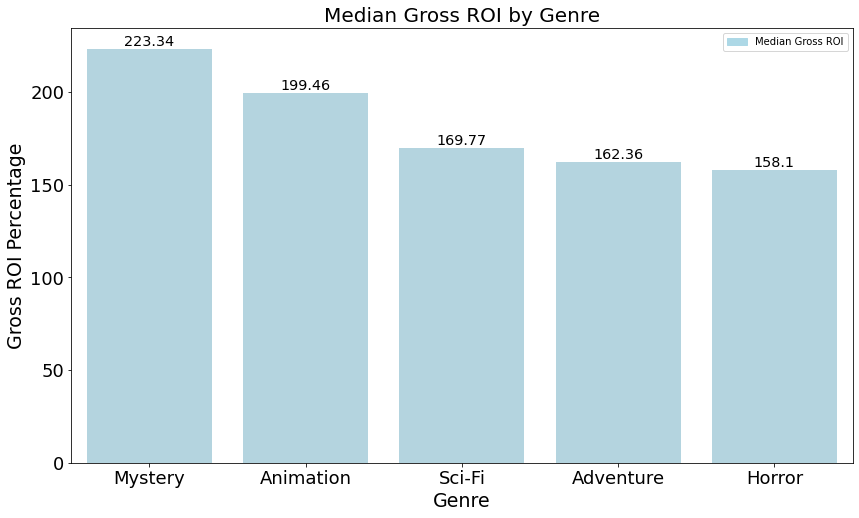

In [3190]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="genre",  y='gross_roi', data=genre_roi_df, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Median Gross ROI')
plt.legend(handles=[bar])

for index, row in genre_roi_df.iterrows():
    ax1.text(row.name, row['gross_roi'], row['gross_roi'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title("Median Gross ROI by Genre",fontsize=20)
plt.xlabel('Genre',fontsize=19)
plt.ylabel('Gross ROI Percentage',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

In [3191]:
month_df = combined_df[['movie', 'gross_roi', 'month']]

In [3193]:
month_df = month_df.drop_duplicates()

In [3195]:
month_roi_df = month_df.groupby('month')[['gross_roi']].median().reset_index()

In [3196]:
month_roi_df = month_roi_df[['month','gross_roi']].sort_values(by='gross_roi',ascending=False).reset_index(drop=True).head()

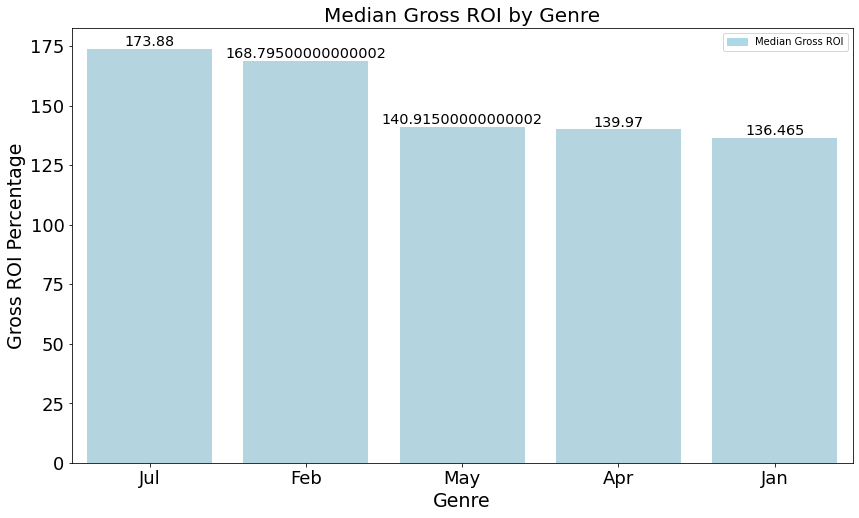

In [3197]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="month",  y='gross_roi', data=month_roi_df, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Median Gross ROI')
plt.legend(handles=[bar])

for index, row in month_roi_df.iterrows():
    ax1.text(row.name, row['gross_roi'], row['gross_roi'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title("Median Gross ROI by Month",fontsize=20)
plt.xlabel('Month',fontsize=19)
plt.ylabel('Gross ROI Percentage',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

In [3198]:
director_roi_df = combined_df[['movie','primary_name','gross_roi']]

In [3199]:
director_roi_df = director_roi_df.groupby('primary_name')[['gross_roi', 'movie']].agg({'gross_roi':'median','movie':'count'}).sort_values(by='gross_roi',ascending=False)

In [3200]:
director_roi_df = director_roi_df[director_roi_df['movie']>=5].head(10).reset_index()

In [3201]:
director_roi_df

,primary_name,gross_roi,movie
0,David O. Russell,544.700,5
1,Tim Story,514.940,7
2,Jon M. Chu,358.885,6
3,Mike Mitchell,320.290,5
4,Francis Lawrence,305.620,5
5,Steven Spielberg,259.500,7
6,Brad Peyton,256.710,5
7,Jaume Collet-Serra,240.310,5
8,Peter Farrelly,211.650,5
9,Ridley Scott,164.970,6


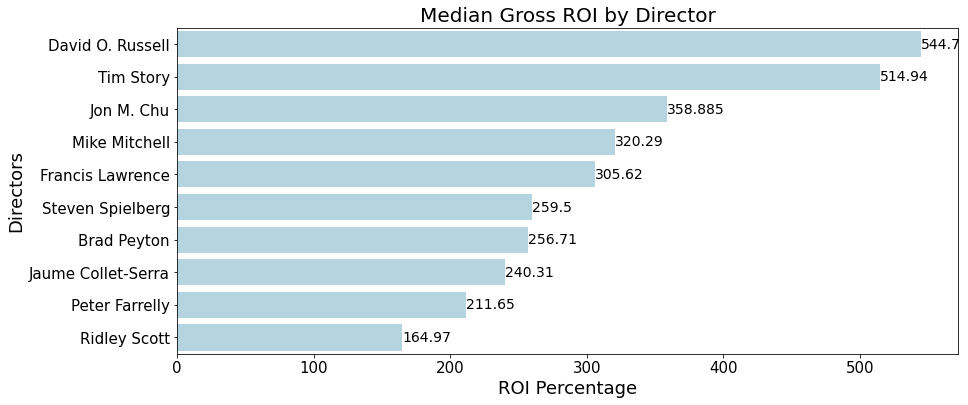

In [3209]:
plt.figure(figsize=(14, 6))

ax1 = sns.barplot(x="gross_roi",  y='primary_name', data=director_roi_df, color='lightblue')

ax1.bar_label(ax1.containers[0],size=14)
# show the graph

plt.title('Median Gross ROI by Director',fontsize=20)
plt.xlabel('ROI Percentage',fontsize=18)
plt.ylabel('Directors',fontsize=18)
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.show()

#Another way to do bar label that i learned about on stackoverflow.
#(https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn)

# Exploratory Analysis

# Conclusions

## Limitations

## Recommendations

## Next Steps